## XDAWN Decoding from EEG data
* XDAWN converts channels and events to create feature vectors that can be fed into a logistic regression ([MNE documentation](https://www.martinos.org/mne/stable/auto_examples/decoding/plot_decoding_xdawn_eeg.html))
* This is a first attempt at exploring machine learning with EEG data. This method will produce a confusion matrix of event_ids.
* Note: This code is NOT mine, but is taken from the link above and adjusted for data used in project.  

In [60]:
# Authors: Alexandre Barachant <alexandre.barachant@gmail.com>
#
# License: BSD (3-clause)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

import mne
from mne import io, pick_types, read_events, Epochs
# from mne.datasets import sample
from mne.preprocessing import Xdawn
from mne.decoding import Vectorizer
from mne.viz import tight_layout

import os
import os.path as op

matplotlib.rcParams['figure.figsize'] = (15.0, 10.0)
matplotlib.rcParams.update({'font.size': 15})

#data path for each run of each subject.
drive_data_path = 'E:\eeg_data'

#data path on my external hdd for folder containing all tests of each subject in one file
drive_all_data_path = 'E:\eeg_data\ica_140_500_0.1'



The documentations starts with raw data, however we alreaday have epoched data with events and event id's. 

In [118]:
epochs = mne.read_epochs(op.join(drive_data_path, 'Ex10_Suj1_Run1-epo.fif'),
                          preload=True)
# epochs.info

Reading E:\eeg_data\Ex10_Suj1_Run1-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
280 matching events found
Created an SSP operator (subspace dimension = 1)
280 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [119]:
# the 61st channel produces an error when computin eigenvalues with cross-validation.
# will use channels 0-60 instead.
epochs = epochs.pick_channels(epochs.ch_names[:60])

In [120]:
#create classification pipeline
clf = make_pipeline(Xdawn(n_components = 3),
                    Vectorizer(),
                    MinMaxScaler(),
                    LogisticRegression(penalty='l1'))
#cross validator
cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)


#Do cross-validation
labels = epochs.events[:,-1]
preds = np.empty(len(labels))
for train, test in cv.split(epochs, labels):
    clf.fit(epochs[train], labels[train])
    preds[test] = clf.predict(epochs[test])

In [124]:
target_names = ['after', 'before', 'new', 'scramble']
report = classification_report(labels, preds, target_names=target_names)
print(report)

             precision    recall  f1-score   support

     before       0.24      0.25      0.24        71
      after       0.55      0.54      0.55        70
        new       0.26      0.26      0.26        69
   scramble       0.33      0.31      0.32        70

avg / total       0.35      0.34      0.34       280



In [122]:
# Normalized confusion matrix
cm = confusion_matrix(labels, preds)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

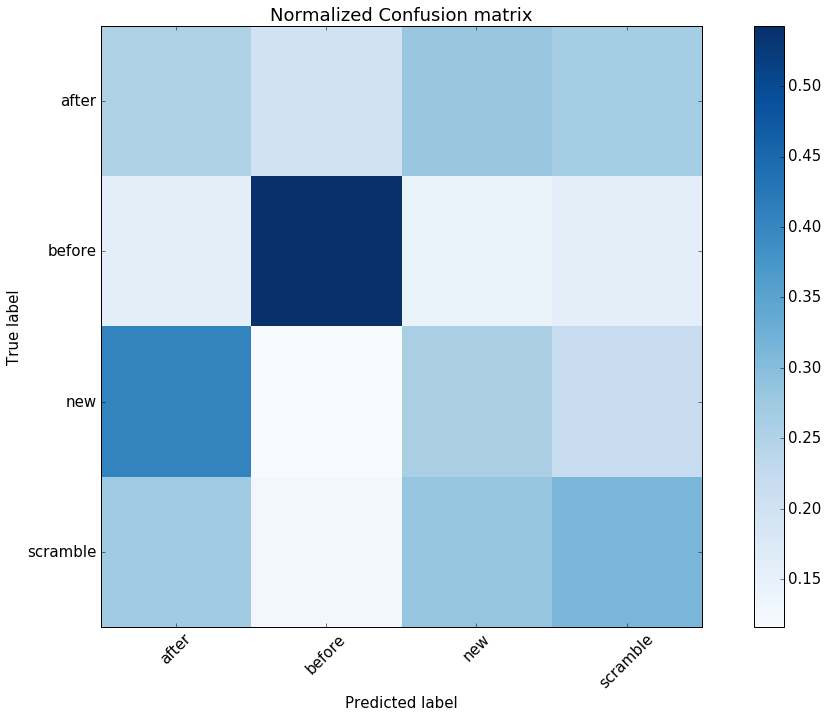

In [123]:
# Plot confusion matrix
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()